# Reconstructor

Use a VAE to reconstruct the images from a fragment.

In [9]:
%watermark -a "Lorenzo Cardarelli" -iv -v -m

Author: Lorenzo Cardarelli

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit

numpy      : 1.24.3
cv2        : 4.8.0
PIL        : 9.5.0
seaborn    : 0.12.2
watermark  : 2.4.3
skimage    : 0.21.0
pandas     : 2.0.2
matplotlib : 3.7.1
torch      : 2.0.1+cu118
torchvision: 0.15.2+cu118
scipy      : 1.11.3



## Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import median
from skimage.morphology import disk

# pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.optim as optim


# training and utils imports
from sklearn.model_selection import train_test_split
from torchinfo import summary
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from tqdm import tqdm

from utils import *
from models import *
from dataset import *

from utils import denoise_and_binarize

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
define_reproducibility(42)

Reproducibility is set to 42.


### Prepare data

In [4]:
pots = load_pots('new_dataset.npz').reshape(-1, 256, 256)

In [5]:
tabular_data = pd.read_excel('selected_info_new_dataset.xlsx')

In [6]:
encoders = fit_and_transform_encoders(tabular_data, ["Functional_class", "Morphology"])
transformed_data = transform_data_using_encoders(tabular_data[["Functional_class","Morphology"]], encoders)

Define some hyperparameters.

In [8]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
IMG_SIZE = 128
LATENT_DIMS = 100

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE, antialias=True),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, (0.01,0.01))
    ])

Train and test plit.

In [10]:
test_size = 0.2

num_samples = len(tabular_data)
num_samples_test = int(test_size * num_samples)


indices = list(range(num_samples))
indices_train, indices_test = train_test_split(indices, test_size=test_size, random_state=42)


pots_train = pots[tabular_data.index][indices_train]
functional_encoded_train = transformed_data.values[indices_train]

pots_test = pots[tabular_data.index][indices_test]
functional_encoded_test = transformed_data.values[indices_test]

In [11]:
len(pots_train), len(pots_test)

(3090, 773)

In [12]:
pots_pytorch_trn = PotTorch(pots_train, functional_encoded_train, transform=transform, img_size=IMG_SIZE)
pots_pytorch_tst = PotTorch(pots_test, functional_encoded_test, transform=transform, img_size=IMG_SIZE)

In [13]:
data_loader_train = DataLoader(dataset = pots_pytorch_trn, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset = pots_pytorch_tst, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [14]:
pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, mask, x_filled = next(iter(data_loader_train))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


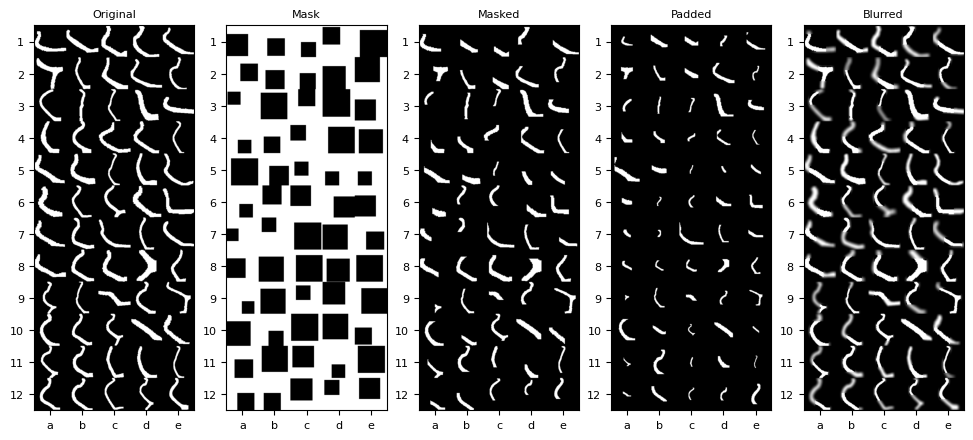

In [15]:
plot_batches([pot[:60], mask[:60], masked_img[:60], padded_tensor[:60], x_filled[:60]], title_list=["Original", "Mask", "Masked", "Padded", "Blurred"], 
             figsize=(12, 8), nrow=5, title_size=8, tick_size=8, save_fig=True)

## MSE

In [17]:
vae = reconstructionVAE(image_latent_dims=LATENT_DIMS).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
custom_loss = CustomLossMSE(mask_weight=0.2)

### Load weights

In [18]:
### Create a list to store the losses over training
train_losses = []
test_losses = []
outputs_train = []
outputs_test = []


for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    ### Set the model to train mode
    vae.train()
    total_loss_train = 0
    for batch, (pot, masked, padded_tensor, bounding_box, scale_factor, archeo_info, mask, _) in enumerate(data_loader_train):
        
        ### Move the data to the device (GPU if available).
        pot = pot.to(device).float()
        masked = masked.to(device).float()
        
        ### Invert the mask
        inverted_mask = ~mask
        inverted_mask = inverted_mask.to(device).float()
        
        ### Forwards pass        
        encoded, z_mean, z_log_var, decoded = vae(masked)                                
                
        ### Calculate the KL divergence
        kl_div = kl_divergence(z_log_var, z_mean)
        batchsize = kl_div.size(0)
        kl_div = kl_div.mean() 

        ### Calculate the pixelwise loss
        pixelwise = custom_loss(pot, decoded, inverted_mask)

        ### Calculate the total loss
        loss_total_train = pixelwise + kl_div


        ### Backpropagation
        optimizer.zero_grad()
        loss_total_train.backward()
        optimizer.step()

        ### Update the total loss   
        total_loss_train += loss_total_train.item()

    ### Calculate the average loss over the epoch
    average_loss = total_loss_train / len(data_loader_train)
    
    ### Append the average loss to the list of losses
    train_losses.append(average_loss)
    outputs_train.append((epoch, decoded, masked, pot))

    ### Set the model to evaluation mode
    vae.eval()

    total_test_loss = 0


    with torch.no_grad():
        for batch_idx, (pot, masked, padded_tensor, bounding_box, scale_factor, archeo_info, mask, _) in enumerate(data_loader_test):
            
            ### Move the data to the device (GPU if available).
            pot = pot.to(device).float()
            masked = masked.to(device).float()


            
            ### Invert the mask
            inverted_mask = ~mask
            inverted_mask = inverted_mask.to(device).float()
            
            ### Forwards pass        
            encoded, z_mean, z_log_var, decoded = vae(masked)                                
                    
            ### Calculate the KL divergence
            kl_div = kl_divergence(z_log_var, z_mean)
            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() 

            ### Calculate the pixelwise loss
            pixelwise = custom_loss(pot, decoded, inverted_mask)

            ### Calculate the total loss
            loss_total_test = pixelwise + kl_div

            total_test_loss += loss_total_test.item()
        
        ### Calculate the average loss over the epoch
        average_loss_test = total_test_loss / len(data_loader_test)

        ### Append the average loss to the list of losses
        test_losses.append(average_loss_test)
        outputs_test.append((epoch, decoded, masked, pot))


    tqdm.write(f'Epoch [{epoch + 1}/{EPOCHS}] - Training Loss: {average_loss:.4f} - Testing Loss: {average_loss_test:.4f}')

Training Progress:   2%|▏         | 1/50 [00:20<16:35, 20.32s/it]

Epoch [1/50] - Training Loss: 235050.4551 - Testing Loss: 187482.6849


Training Progress:   4%|▍         | 2/50 [00:41<16:36, 20.76s/it]

Epoch [2/50] - Training Loss: 144330.9329 - Testing Loss: 122045.2552


Training Progress:   6%|▌         | 3/50 [01:01<15:53, 20.30s/it]

Epoch [3/50] - Training Loss: 96931.3870 - Testing Loss: 84412.5755


Training Progress:   8%|▊         | 4/50 [01:24<16:29, 21.51s/it]

Epoch [4/50] - Training Loss: 78075.8893 - Testing Loss: 73465.4570


Training Progress:  10%|█         | 5/50 [01:44<15:50, 21.11s/it]

Epoch [5/50] - Training Loss: 67978.3758 - Testing Loss: 63636.9596


Training Progress:  12%|█▏        | 6/50 [02:09<16:19, 22.26s/it]

Epoch [6/50] - Training Loss: 62148.5754 - Testing Loss: 59665.7767


Training Progress:  14%|█▍        | 7/50 [02:28<15:18, 21.37s/it]

Epoch [7/50] - Training Loss: 59897.4227 - Testing Loss: 58775.7695


Training Progress:  16%|█▌        | 8/50 [02:48<14:31, 20.74s/it]

Epoch [8/50] - Training Loss: 56974.6867 - Testing Loss: 57847.2174


Training Progress:  18%|█▊        | 9/50 [03:08<13:58, 20.46s/it]

Epoch [9/50] - Training Loss: 54400.8389 - Testing Loss: 54526.2923


Training Progress:  20%|██        | 10/50 [03:27<13:26, 20.16s/it]

Epoch [10/50] - Training Loss: 53404.9894 - Testing Loss: 53090.6146


Training Progress:  22%|██▏       | 11/50 [03:48<13:12, 20.32s/it]

Epoch [11/50] - Training Loss: 53662.1390 - Testing Loss: 51593.7240


Training Progress:  24%|██▍       | 12/50 [04:08<12:50, 20.28s/it]

Epoch [12/50] - Training Loss: 50493.5200 - Testing Loss: 49499.2559


Training Progress:  26%|██▌       | 13/50 [04:28<12:28, 20.23s/it]

Epoch [13/50] - Training Loss: 49300.7129 - Testing Loss: 50966.9414


Training Progress:  28%|██▊       | 14/50 [04:49<12:11, 20.32s/it]

Epoch [14/50] - Training Loss: 50465.7539 - Testing Loss: 47659.3633


Training Progress:  30%|███       | 15/50 [05:08<11:43, 20.11s/it]

Epoch [15/50] - Training Loss: 47859.2114 - Testing Loss: 47225.3978


Training Progress:  32%|███▏      | 16/50 [05:28<11:19, 19.98s/it]

Epoch [16/50] - Training Loss: 46632.9147 - Testing Loss: 46921.8385


Training Progress:  34%|███▍      | 17/50 [05:48<10:59, 19.98s/it]

Epoch [17/50] - Training Loss: 48005.9346 - Testing Loss: 46577.4740


Training Progress:  36%|███▌      | 18/50 [06:08<10:39, 19.99s/it]

Epoch [18/50] - Training Loss: 46349.6270 - Testing Loss: 46738.1771


Training Progress:  38%|███▊      | 19/50 [06:28<10:19, 19.98s/it]

Epoch [19/50] - Training Loss: 45962.1942 - Testing Loss: 45205.5495


Training Progress:  40%|████      | 20/50 [06:48<10:00, 20.02s/it]

Epoch [20/50] - Training Loss: 45290.1156 - Testing Loss: 46617.4062


Training Progress:  42%|████▏     | 21/50 [07:08<09:40, 20.02s/it]

Epoch [21/50] - Training Loss: 45488.1032 - Testing Loss: 44675.4434


Training Progress:  44%|████▍     | 22/50 [07:28<09:18, 19.94s/it]

Epoch [22/50] - Training Loss: 44441.3140 - Testing Loss: 43742.7142


Training Progress:  46%|████▌     | 23/50 [07:48<08:57, 19.90s/it]

Epoch [23/50] - Training Loss: 44432.4043 - Testing Loss: 44968.3418


Training Progress:  48%|████▊     | 24/50 [08:07<08:35, 19.81s/it]

Epoch [24/50] - Training Loss: 44537.1802 - Testing Loss: 43199.1484


Training Progress:  50%|█████     | 25/50 [08:27<08:16, 19.86s/it]

Epoch [25/50] - Training Loss: 43715.3288 - Testing Loss: 43864.2897


Training Progress:  52%|█████▏    | 26/50 [08:47<07:54, 19.75s/it]

Epoch [26/50] - Training Loss: 44736.1509 - Testing Loss: 46802.5840


Training Progress:  54%|█████▍    | 27/50 [09:07<07:35, 19.79s/it]

Epoch [27/50] - Training Loss: 43794.9618 - Testing Loss: 41361.0078


Training Progress:  56%|█████▌    | 28/50 [09:26<07:14, 19.75s/it]

Epoch [28/50] - Training Loss: 43640.1768 - Testing Loss: 42143.3203


Training Progress:  58%|█████▊    | 29/50 [09:46<06:54, 19.75s/it]

Epoch [29/50] - Training Loss: 42745.9150 - Testing Loss: 42121.4902


Training Progress:  60%|██████    | 30/50 [10:06<06:36, 19.85s/it]

Epoch [30/50] - Training Loss: 43091.4189 - Testing Loss: 43081.3255


Training Progress:  62%|██████▏   | 31/50 [10:26<06:15, 19.78s/it]

Epoch [31/50] - Training Loss: 42167.8581 - Testing Loss: 41272.2786


Training Progress:  64%|██████▍   | 32/50 [10:46<05:57, 19.86s/it]

Epoch [32/50] - Training Loss: 42862.2619 - Testing Loss: 43891.0130


Training Progress:  66%|██████▌   | 33/50 [11:06<05:39, 19.96s/it]

Epoch [33/50] - Training Loss: 42049.7388 - Testing Loss: 41955.6016


Training Progress:  68%|██████▊   | 34/50 [11:26<05:20, 20.06s/it]

Epoch [34/50] - Training Loss: 41553.6120 - Testing Loss: 42258.7122


Training Progress:  70%|███████   | 35/50 [11:46<05:01, 20.11s/it]

Epoch [35/50] - Training Loss: 41801.2983 - Testing Loss: 42685.1387


Training Progress:  72%|███████▏  | 36/50 [12:07<04:41, 20.10s/it]

Epoch [36/50] - Training Loss: 41155.9147 - Testing Loss: 42430.4987


Training Progress:  74%|███████▍  | 37/50 [12:26<04:20, 20.01s/it]

Epoch [37/50] - Training Loss: 40814.8789 - Testing Loss: 40466.6367


Training Progress:  76%|███████▌  | 38/50 [12:47<04:01, 20.10s/it]

Epoch [38/50] - Training Loss: 40561.2775 - Testing Loss: 40618.0111


Training Progress:  78%|███████▊  | 39/50 [13:07<03:43, 20.33s/it]

Epoch [39/50] - Training Loss: 40793.7531 - Testing Loss: 41459.0000


Training Progress:  80%|████████  | 40/50 [13:31<03:32, 21.27s/it]

Epoch [40/50] - Training Loss: 40889.7684 - Testing Loss: 40495.9173


Training Progress:  82%|████████▏ | 41/50 [13:59<03:28, 23.20s/it]

Epoch [41/50] - Training Loss: 39902.5907 - Testing Loss: 39498.8711


Training Progress:  84%|████████▍ | 42/50 [14:27<03:17, 24.66s/it]

Epoch [42/50] - Training Loss: 40255.4131 - Testing Loss: 40542.9147


Training Progress:  86%|████████▌ | 43/50 [14:56<03:01, 25.92s/it]

Epoch [43/50] - Training Loss: 40809.6761 - Testing Loss: 41894.6009


Training Progress:  88%|████████▊ | 44/50 [15:25<02:41, 26.87s/it]

Epoch [44/50] - Training Loss: 40689.9689 - Testing Loss: 41625.0091


Training Progress:  90%|█████████ | 45/50 [15:55<02:19, 27.83s/it]

Epoch [45/50] - Training Loss: 40529.2007 - Testing Loss: 40486.3542


Training Progress:  92%|█████████▏| 46/50 [16:25<01:54, 28.53s/it]

Epoch [46/50] - Training Loss: 40776.8835 - Testing Loss: 41751.6732


Training Progress:  94%|█████████▍| 47/50 [16:54<01:26, 28.77s/it]

Epoch [47/50] - Training Loss: 39977.9513 - Testing Loss: 40199.5690


Training Progress:  96%|█████████▌| 48/50 [17:24<00:58, 29.14s/it]

Epoch [48/50] - Training Loss: 39868.7511 - Testing Loss: 40216.1921


Training Progress:  98%|█████████▊| 49/50 [17:54<00:29, 29.36s/it]

Epoch [49/50] - Training Loss: 39220.1506 - Testing Loss: 38885.1361


Training Progress: 100%|██████████| 50/50 [18:24<00:00, 22.08s/it]

Epoch [50/50] - Training Loss: 40250.4030 - Testing Loss: 41778.8665


In [29]:
train_losses_array_MSE = np.array(train_losses)
test_losses_array_MSE = np.array(test_losses)

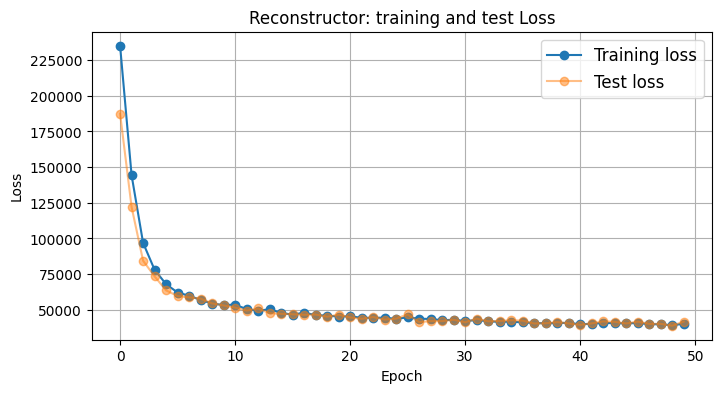

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(train_losses_array_MSE, label='Training loss', marker='o', linestyle='-')
plt.plot(test_losses_array_MSE, label='Test loss', marker='o', linestyle='-', alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstructor: training and test Loss')

plt.legend(frameon=True, loc='upper right', fontsize='large')

# Display a grid for readability
plt.grid(True)

# Show the plot


plt.savefig('Reconstructor_training_test_loss.png', dpi=300, bbox_inches='tight');

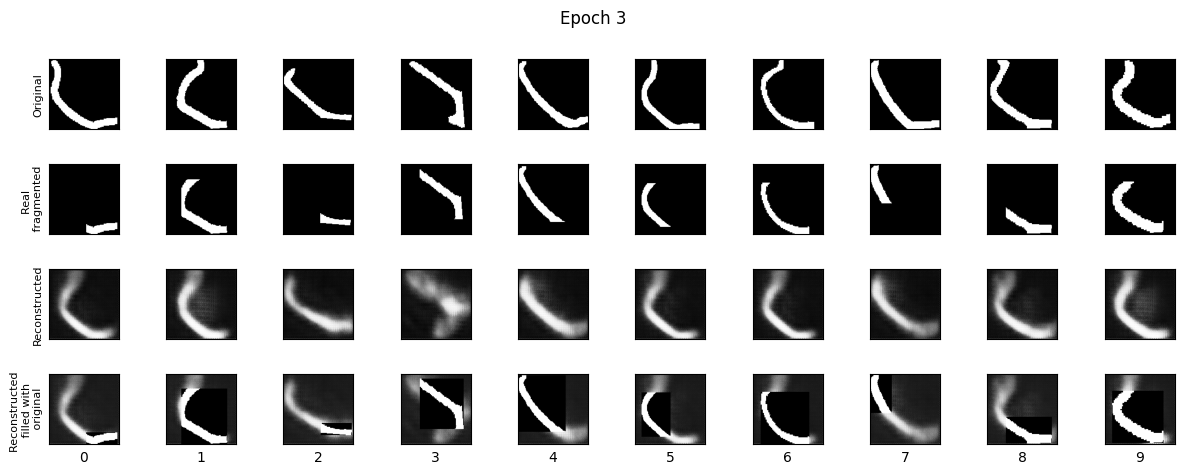

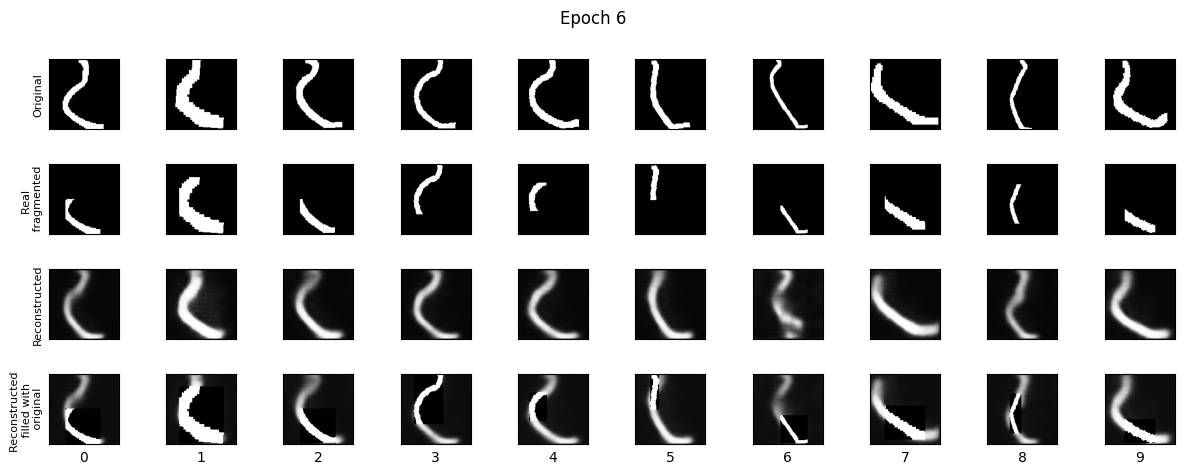

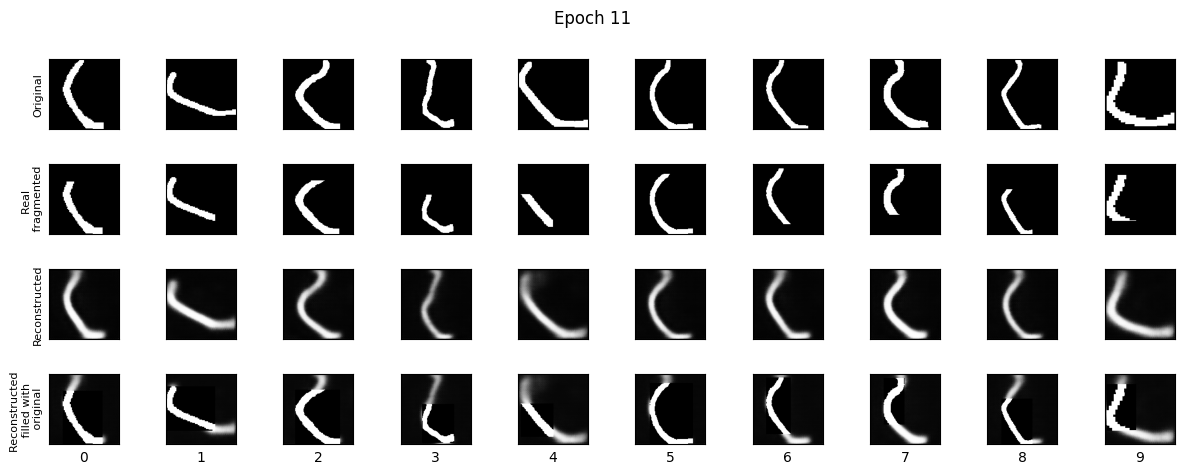

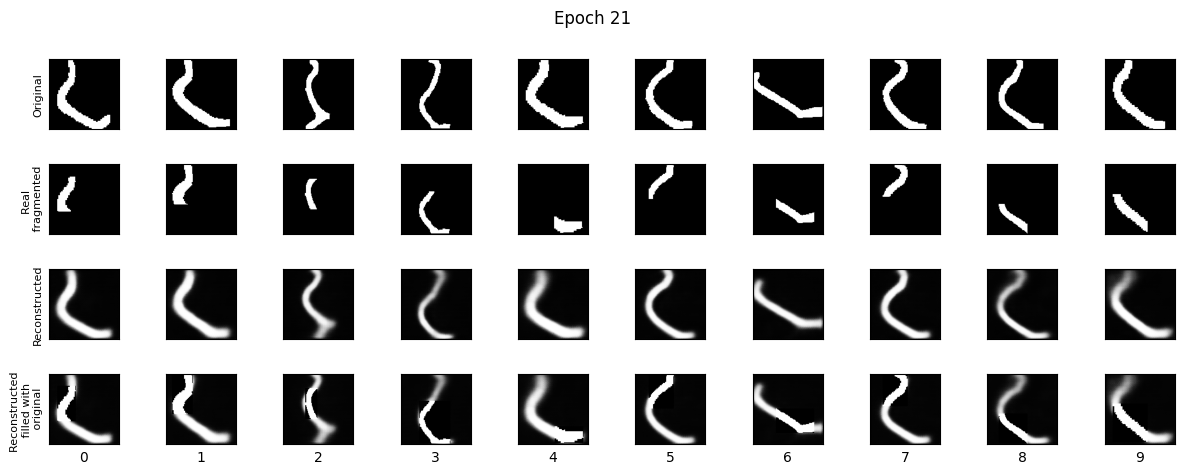

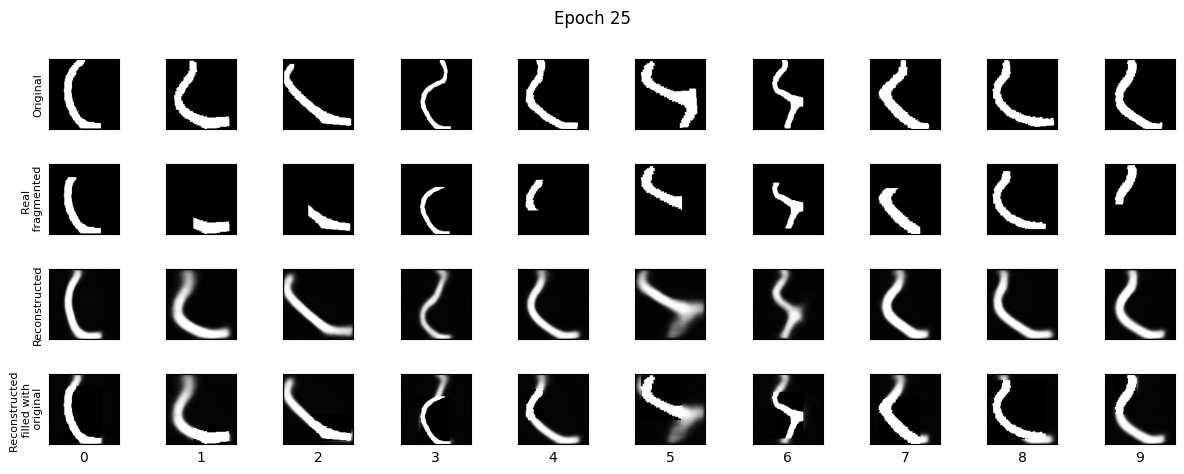

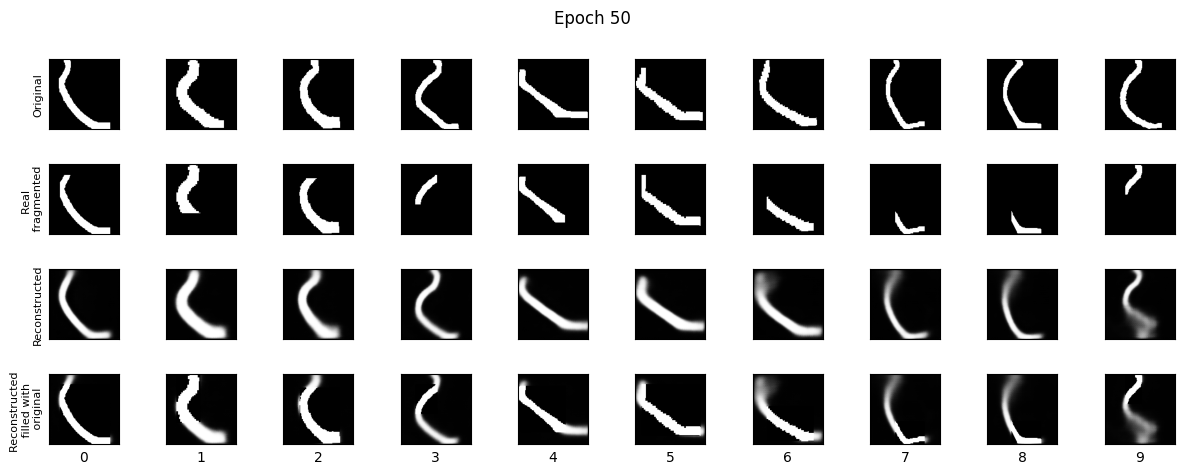

In [32]:
for k in [2,5,10, 20, 24, 49]:


    decoded_tensor = outputs_train[k][1].to("cpu").detach()
    masked_tensor = outputs_train[k][2].to("cpu").detach()
    pot_tensor = outputs_train[k][3].to("cpu").detach()


    row_mask = torch.all(torch.eq(masked_tensor, 0), dim=3, keepdim=True)
    col_mask = torch.all(torch.eq(masked_tensor, 0), dim=2, keepdim=True)
    x_filled = torch.where(row_mask, decoded_tensor, pot_tensor)
    decoded_filled = torch.where(col_mask, decoded_tensor, x_filled)

    decoded = decoded_tensor.numpy()
    masked = masked_tensor.numpy()
    pot = pot_tensor.numpy()
    decoded_filled = decoded_filled.numpy()

    plt_number = 10

    fig, ax = plt.subplots(4, int(plt_number), figsize=(15, 5),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.5, wspace=0.1))
    plt.suptitle(f"Epoch {k+1}")
    for i in range(int(plt_number)):
        ax[0, i].imshow(np.transpose(pot[i], (1,2,0)), cmap='binary_r')
        ax[1, i].imshow(np.transpose(masked[i],(1,2,0)), cmap='binary_r')
        ax[2, i].imshow(np.transpose(decoded[i],(1,2,0)), cmap='binary_r')
        ax[3, i].imshow(np.transpose(decoded_filled[i],(1,2,0)), cmap='binary_r')
        ax[0, 0].set_ylabel('Original', fontsize=8)
        ax[1, 0].set_ylabel('Real \n fragmented', fontsize=8)
        ax[2, 0].set_ylabel('Reconstructed', fontsize=8)
        ax[3, 0].set_ylabel('Reconstructed \n filled with \n original', fontsize=8)
        ax[3, i].set_xlabel(i)

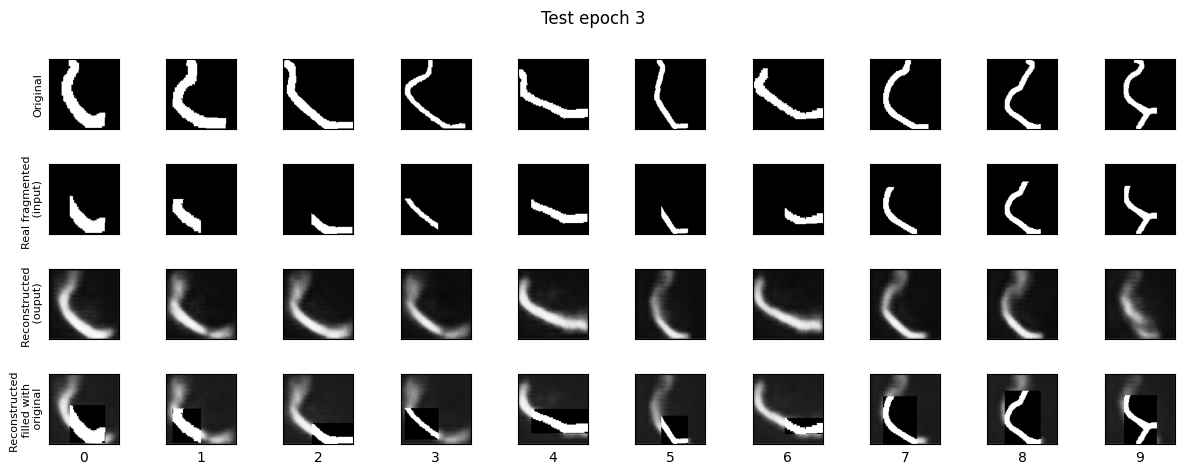

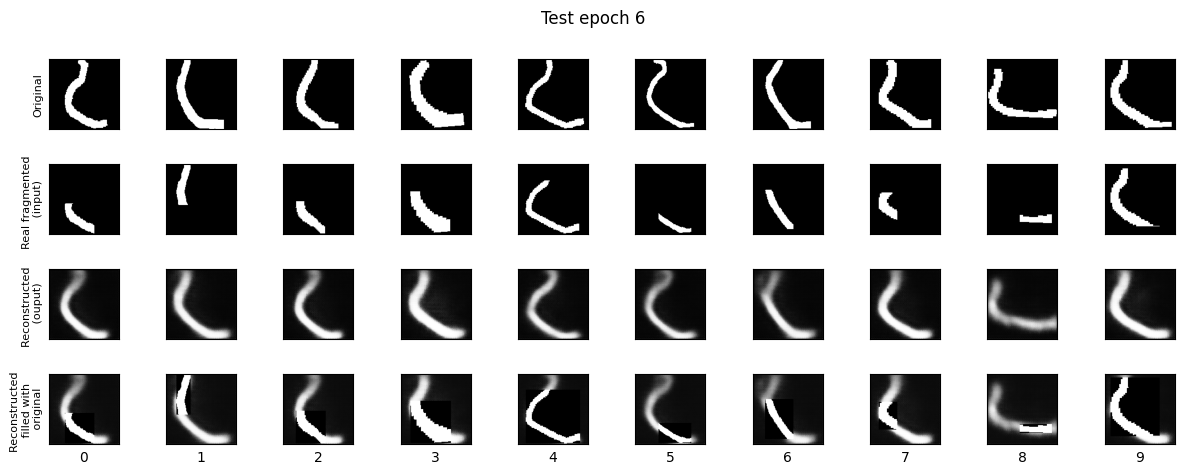

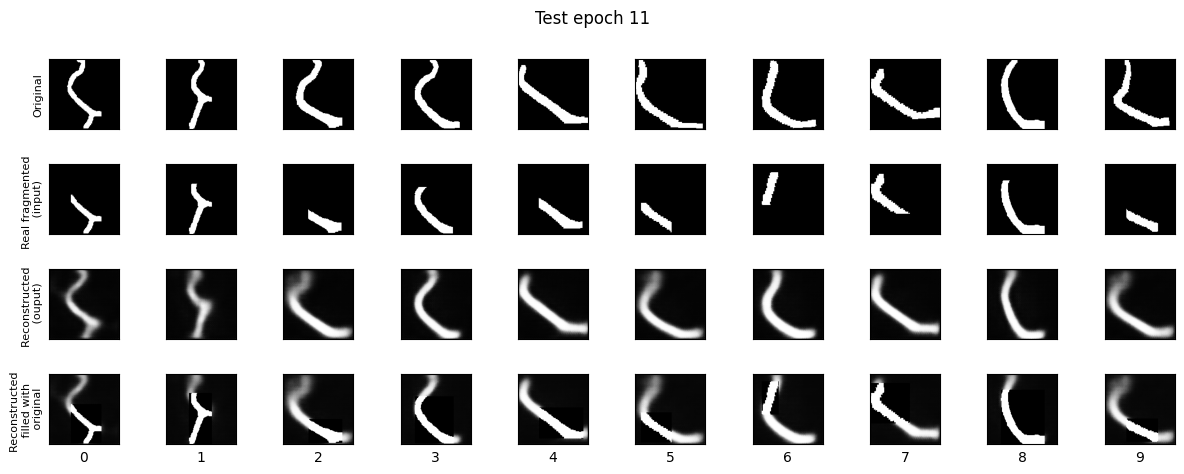

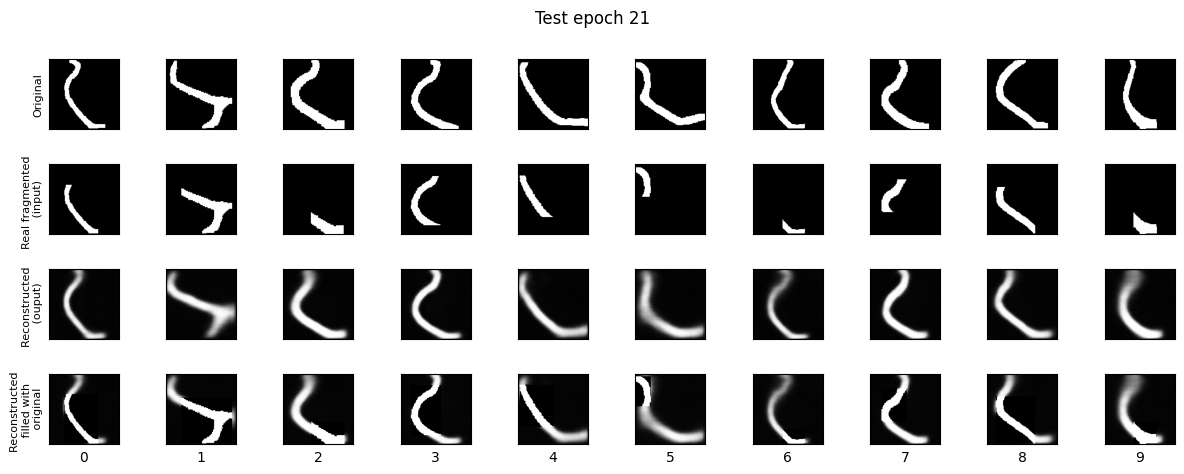

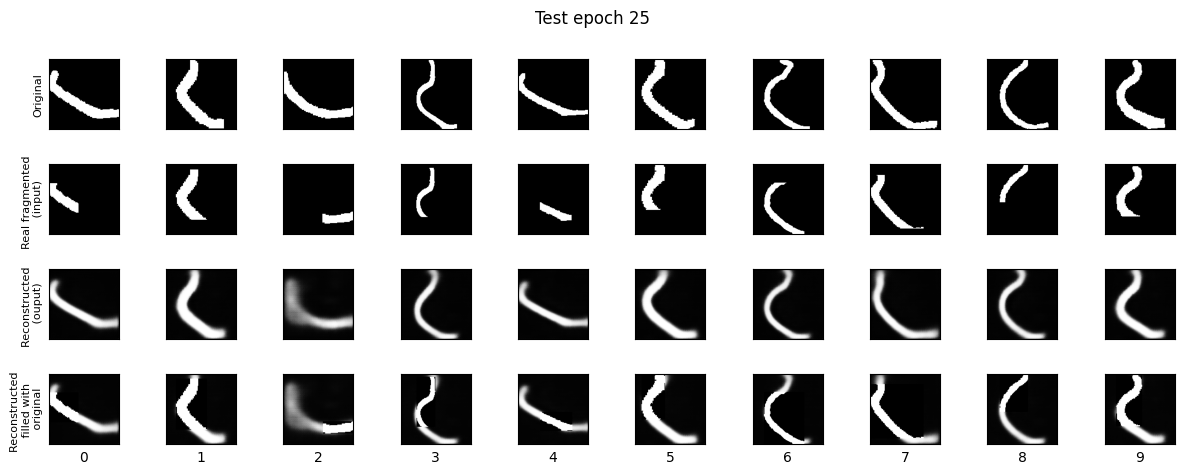

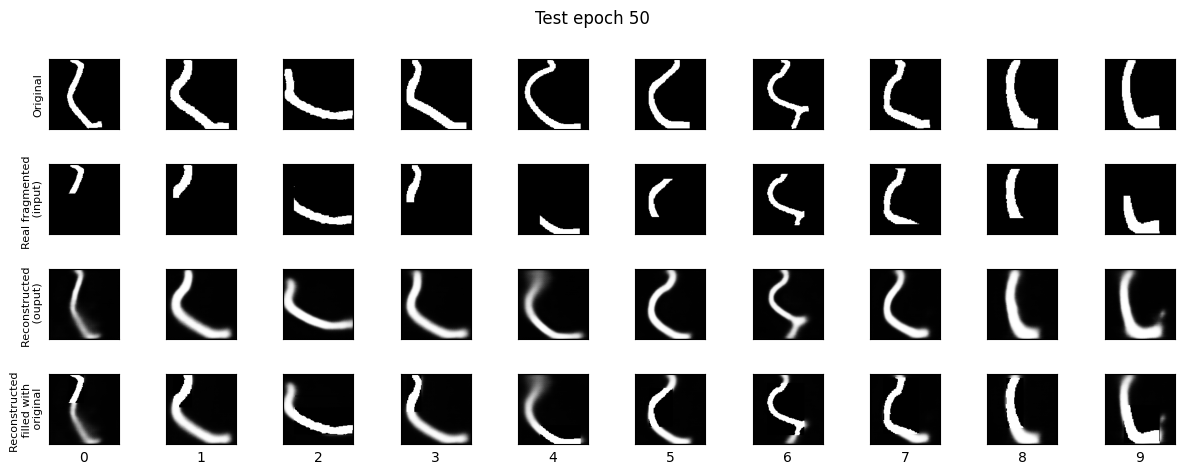

In [35]:
for k in [2,5,10, 20, 24, 49]:


    decoded_tensor = outputs_test[k][1].to("cpu").detach()
    masked_tensor = outputs_test[k][2].to("cpu").detach()
    pot_tensor = outputs_test[k][3].to("cpu").detach()


    row_mask = torch.all(torch.eq(masked_tensor, 0), dim=3, keepdim=True)
    col_mask = torch.all(torch.eq(masked_tensor, 0), dim=2, keepdim=True)
    x_filled = torch.where(row_mask, decoded_tensor, pot_tensor)
    decoded_filled = torch.where(col_mask, decoded_tensor, x_filled)

    decoded = decoded_tensor.numpy()
    masked = masked_tensor.numpy()
    pot = pot_tensor.numpy()
    decoded_filled = decoded_filled.numpy()

    plt_number = 10

    fig, ax = plt.subplots(4, int(plt_number), figsize=(15, 5),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.5, wspace=0.1))
    plt.suptitle(f"Test epoch {k+1}")
    for i in range(int(plt_number)):
        ax[0, i].imshow(np.transpose(pot[i], (1,2,0)), cmap='binary_r')
        ax[1, i].imshow(np.transpose(masked[i],(1,2,0)), cmap='binary_r')
        ax[2, i].imshow(np.transpose(decoded[i],(1,2,0)), cmap='binary_r')
        ax[3, i].imshow(np.transpose(decoded_filled[i],(1,2,0)), cmap='binary_r')
        ax[0, 0].set_ylabel('Original', fontsize=8)
        ax[1, 0].set_ylabel('Real fragmented \n (input)', fontsize=8)
        ax[2, 0].set_ylabel('Reconstructed \n (ouput)', fontsize=8)
        ax[3, 0].set_ylabel('Reconstructed \n filled with \n original', fontsize=8)
        ax[3, i].set_xlabel(i)
    
    if k == 49:
        plt.savefig('Reconstructor_test_epoch_50.png', dpi=300, bbox_inches='tight');

### Reconstruction metrics

I'm going to define the reconstruction metrics using the following output:
- Decoder output (raw output of the decoder).
- Decoder output filled (decoder output superimposed on the original fragment image).
- Denoised Decoder output filled.

In [36]:
pots_metrics = []
decoded_metrics = []
masks_metrics = []
encoded_metrics = []

with torch.no_grad():
    for batch_idx, (pot, masked, padded_tensor, bounding_box, scale_factor, archeo_info, mask, _) in enumerate(data_loader_test):
            
        ### Move the data to the device (GPU if available).
        pot = pot.to(device).float()
        masked = masked.to(device).float()

            
        ### Invert the mask
        inverted_mask = ~mask
        inverted_mask = inverted_mask.to(device).float()
            
        ### Forwards pass        
        encoded, z_mean, z_log_var, decoded = vae(masked)

        pots_metrics.extend(pot)
        decoded_metrics.extend(decoded) 
        masks_metrics.extend(masked)
        encoded_metrics.append(encoded)                         

In [37]:
# Concatena lungo la dimensione del batch
pots_metrics = torch.cat(pots_metrics, dim=0)
decoded_metrics = torch.cat(decoded_metrics, dim=0)
masks_metrics = torch.cat(masks_metrics, dim=0)
encoded_metrics = torch.cat(encoded_metrics)

In [38]:
pots_metrics = pots_metrics.unsqueeze(1)
decoded_metrics = decoded_metrics.unsqueeze(1)
masks_metrics = masks_metrics.unsqueeze(1)

In [39]:
row_mask = torch.all(torch.eq(masks_metrics, 0), dim=3, keepdim=True)
col_mask = torch.all(torch.eq(masks_metrics, 0), dim=2, keepdim=True)
x_filled = torch.where(row_mask, decoded_metrics, pots_metrics)
decoded_filled = torch.where(col_mask, decoded_metrics, x_filled)

#### Denoiser

In [40]:
dae = DenoisingAutoencoder(latent_dims=LATENT_DIMS).to(device)
dae.load_state_dict(torch.load('denoiser_new_data.pth'))

<All keys matched successfully>

In [41]:
denoised = dae(decoded_filled)

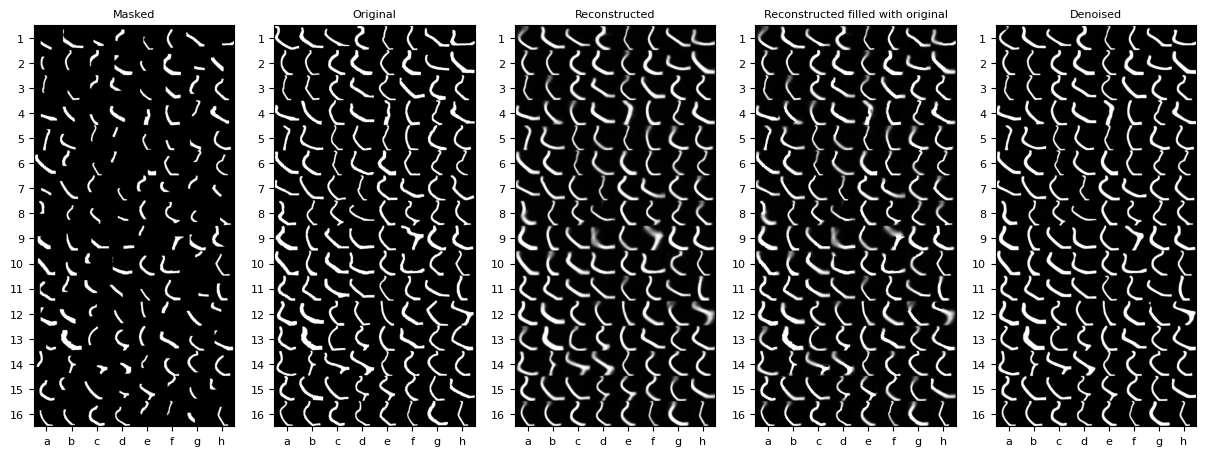

In [55]:
plot_batches([masks_metrics[:128], pots_metrics[:128], decoded_metrics[:128], decoded_filled[:128], denoised[:128]], 
             title_list=['Masked', 'Original', 'Reconstructed', 'Reconstructed filled with original', 'Denoised'],
             figsize=(15, 15), tick_size=8, title_size=8, save_fig=True)

In [43]:
original_numpy = pots_metrics.detach().cpu().numpy()
decoded_simple_numpy = decoded_metrics.detach().cpu().numpy()
decoded_filled_numpy = decoded_filled.detach().cpu().numpy()
denoised_numpy = denoised.detach().cpu().numpy()
mask_numpy = masks_metrics.detach().cpu().numpy()

# reshape in numpy array
original_numpy = original_numpy.squeeze(1)
decoded_simple_numpy = decoded_simple_numpy.squeeze(1)
decoded_filled_numpy = decoded_filled_numpy.squeeze(1)
denoised_numpy = denoised_numpy.squeeze(1)
mask_numpy = mask_numpy.squeeze(1)

In [44]:
decoded_numpy_binary = []
for i in range(len(decoded_simple_numpy)):
    x = denoise_and_binarize(decoded_simple_numpy[i])
    decoded_numpy_binary.append(x)

decoded_numpy_binary = np.array(decoded_numpy_binary)

decoded_numpy_filled_binary = []
for i in range(len(decoded_filled_numpy)):
    x = denoise_and_binarize(decoded_filled_numpy[i])
    decoded_numpy_filled_binary.append(x)

decoded_numpy_filled_binary = np.array(decoded_numpy_filled_binary)

denoised_numpy_binary = []
for i in range(len(denoised_numpy)):
    x = denoise_and_binarize(denoised_numpy[i])
    denoised_numpy_binary.append(x)

denoised_numpy_binary = np.array(denoised_numpy_binary)

In [45]:
original_numpy = np.array([median(img, disk(3)) for img in original_numpy])

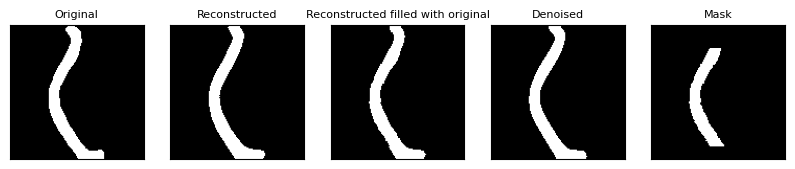

In [48]:
index = 5

fig, ax = plt.subplots(1, 5, figsize=(10, 5))
ax[0].imshow(original_numpy[index], cmap='binary_r')
ax[1].imshow(decoded_numpy_binary[index], cmap='binary_r')
ax[2].imshow(decoded_numpy_filled_binary[index], cmap='binary_r')
ax[3].imshow(denoised_numpy_binary[index], cmap='binary_r')
ax[4].imshow(mask_numpy[index], cmap='binary_r')

ax[0].set_title('Original', fontsize=8)
ax[1].set_title('Reconstructed', fontsize=8)
ax[2].set_title('Reconstructed filled with original', fontsize=8)
ax[3].set_title('Denoised', fontsize=8)
ax[4].set_title('Mask', fontsize=8)

for i in range(5):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [49]:
metrics_reconstructed = reconstruction_metrics(original_numpy, decoded_numpy_binary)
metrics_reconstructed_filled = reconstruction_metrics(original_numpy, decoded_numpy_filled_binary)
metrics_denoised = reconstruction_metrics(original_numpy, denoised_numpy_binary)

In [50]:
metrics_reconstructed.columns = ['Reconstructed vanilla']
metrics_reconstructed_filled.columns = ['Reconstructed filled with original']
metrics_denoised.columns = ['Denoised']

In [51]:
metrics_tabular = pd.concat([metrics_reconstructed, metrics_reconstructed_filled, metrics_denoised], axis=1).round(4)

In [53]:
print(metrics_tabular.to_markdown())

|                  |   Reconstructed vanilla |   Reconstructed filled with original |   Denoised |
|:-----------------|------------------------:|-------------------------------------:|-----------:|
| RMSE             |                  0.2127 |                               0.1772 |     0.187  |
| Dice coefficient |                  0.8441 |                               0.8851 |     0.8721 |
| GS score         |                  0.0012 |                               0.0008 |     0.0013 |
| FID score        |                  0.0174 |                               0.0094 |     0.0018 |


In [46]:
torch.save(vae.state_dict(), "reconstructor_model.pth")